## Overview

Using `bokeh` to define populations for later structure investigation.

Broadly, in theory a population is a freely breeding set of individuals. In practice, it is a set of individuals from the same location which are members of the same species. The idea of location is wooly, but broadly within 50km, and there being an absence of PCA structure within the region.

Logically, the way to approach this is to:

1. Look for pairs/sets of locations very close and collapse.

2. For groups assign a new species, ie intermediate/gam/col/arab. 

3. look at groupby location/species/year and see where we can take a single set. ie >= 10.

4. Assign "unique" locations numeric IDs.

5. Assign samples to groups based on 4 

In [1]:
import gcsfs
import numpy as np
import allel
import yaml
import zarr
import pandas as pd

In [2]:
# let's try bokeh...
# imports required for `bokeh`
from bokeh.plotting import figure, show, ColumnDataSource, output_file
import matplotlib as mpl
import seaborn as sns
from bokeh.layouts import gridplot

In [3]:
# imports needed for clustering
from scipy.spatial.distance import _convert_to_double
import scipy.spatial.distance as distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from cartopy.geodesic import Geodesic
from itertools import combinations

In [4]:
from ag3 import release_data
v3 = release_data()

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
minimum_population_size = 10
threshold_cluster_distance_km = 50

In [6]:
country_id_codes = {
    "Angola": "ANG",
    "Burkina Faso": "BUF",
    "Cameroon": "CMN",
    "Central African Republic": "CAR",
    "Cote d'Ivoire": "CIV",
    "Democratic Republic of Congo": "DRC",
    "Gabon": "GAB",
    "Gambia, The": "GAM",
    "Ghana": "GHA",
    "Guinea": "GUI",
    "Guinea-Bissau": "GBU",
    "Kenya": "KEN",
    "Malawi": "MLW",
    "Mali": "MAL",
    "Mayotte": "MAY",
    "Mozambique": "MOZ",
    "Tanzania": "TZA",
    "Uganda": "UGA"
}

In [7]:
# Data storage, uses about 34 MB
pca_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_output.zarr'
# Writing the PCA data to the cloud will require the appropriate authentication and authorization.

# UNCOMMENT THIS TO AUTHENTICATE. YOU ONLY NEED TO RUN THIS ONCE.
# After running this once, your authentication token should then be cached in `~/.gcs_tokens`
# Once you have authenticated, you should comment this out again to avoid re-authenticating.
# gcs_browser = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='browser')

# Use `cache_timeout=0` to prevent object list cache, to avoid recreating map for Zarr consolidated metadata
auth_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

In [8]:
pca_cloud_zarr_path = pca_cloud_zarr_path_template.format('gamb_colu')
pca_cloud_zarr_path

# Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist
# Keep the zarr_store for zarr.consolidate_metadata(zarr_store)
zarr_store = auth_fs.get_mapper(pca_cloud_zarr_path)
zarr_group = zarr.group(zarr_store)

sample_names = zarr_group["sample_names"][:]
sample_names = [s.decode() for s in sample_names]

pca_coordinates = zarr_group["coords"]
pca_components = zarr_group["components"]
pca_pve = zarr_group["explained_variance_ratio"]

In [9]:
def plot_pca_coords(coords, pve, pc1, pc2, fig, df, group_var, col_dict="auto", query=None):

    x = coords[:, pc1]
    y = coords[:, pc2]
    
    qdf = df.reset_index().copy()
    qdf["x"] = x
    qdf["y"] = y
    
    # apply_query
    if query is not None:
        qdf = qdf.query(query)
    
    g = qdf.groupby(group_var)
    
    if col_dict == "auto":
        cp = sns.color_palette(n_colors=len(g))
        col_dict = {k:v for k, v in zip(g.groups, cp)}
        
    for label, frame in g:
        
        source = ColumnDataSource(data=frame)
        
        fig.circle(
            'x', 'y', 
            source=source,
            line_color='black',
            line_width=0.5,
            size=6,
            fill_color=mpl.colors.rgb2hex(col_dict[label]))
    
    fig.xaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc1 + 1, 100 * pve[pc1])
    
    fig.yaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc2 + 1, 100 * pve[pc2])
    
    return fig

In [10]:
all_meta = v3.load_sample_set_metadata(v3.all_wild_sample_sets, include_aim_species_calls=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [11]:
# This defines what is displayed when the mouse hovers over a point.
# The @ values correspond to values in the table.
TOOLTIPS = [
    ("ox_code", "@sample_id"),
    ("country", "@country"),
    ("location", "@location"),
    ("collection year", "@year"),
    ("species", "@species_gambcolu_arabiensis"),
    ("species_gamcol", "@species_gambiae_coluzzii"),
    ("(x, y)", "($x, $y)"),]

In [12]:
components = np.array(range(8)).reshape((2, 2, 2)).tolist()

In [13]:
def pca_figure_wrapper(filename, qstring):

    output_file(filename)
    grid = []

    for row in components:

        l = []

        for (c1, c2) in row:

            p = figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS)
            l.append(
                plot_pca_coords(
                    pca_coordinates, 
                    pca_pve, 
                    c1, 
                    c2, 
                    p,
                    df_species_samples,
                    "location",
                    col_dict="auto",
                    query=qstring))
                    #"location_label"))

        grid.append(l)

    col = gridplot(grid)
    show(col)

## Location merging

Merge locations that are very close. 

In [14]:
definition_file = "../content/population_definitions.yml"
population_definitions = {}

In [15]:
geo = Geodesic()

In [16]:
locations = all_meta.drop_duplicates(subset="location").reset_index()[["country", "location", "latitude", "longitude"]].set_index(["country", "location"])
locations.head()

latitude  longitude
country      location                           
Angola       Luanda            -8.884     13.302
Burkina Faso Pala              11.150     -4.235
             Bana              11.233     -4.472
             Souroukoudinga    11.235     -4.535
             Monomtenga        12.060     -1.170

In [17]:
condensed_dist_matrix = np.zeros((locations.shape[0] * (locations.shape[0] - 1))//2, dtype=np.float32)
condensed_dist_matrix.shape

(7875,)

In [18]:
len(locations)

126

In [19]:
for a, b in combinations(range(locations.shape[0]), 2):
    
    ix = allel.condensed_coords(a, b, len(locations))
    condensed_dist_matrix[ix] = geo.geometry_length(locations.iloc[[a, b]].values) * 1e-3

In [20]:
# Define functions
def plot_dendrogram(dist, nhaps, method='complete'):
    
    # faff
    y = _convert_to_double(np.asarray(dist, order='c'))
    
    # 2. get n
    n = int(distance.num_obs_y(dist))
    
    # 3. do clustering
    #method = dict(single=0, complete=1)[method]
    z = linkage(y, method)    

    # plot dendrogram
    r = dendrogram(
        z, no_labels=True, count_sort=True,
        #color_threshold=color_threshold, 
        #above_threshold_color=above_threshold_color,
        ax=None)
    
    return z, r

In [21]:
# gives the haplotype indices of the haplotypes in the n largest clusters
def find_clusters(z, n=None, threshold=50):
    
    # find clusters
    f = fcluster(z, threshold, criterion='distance')
    
    # compute cluster sizes
    fsz = np.bincount(f)
    
    # sort largest first
    fsort = np.argsort(fsz)[::-1]
    
    # take largest n
    if n is not None:
        fsort = fsort[:n]
    
    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
    
    return clusters

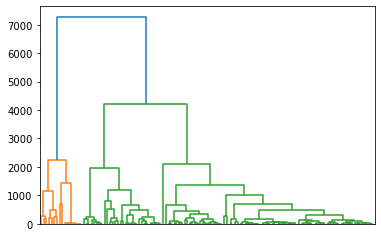

In [22]:
zz, rr = plot_dendrogram(condensed_dist_matrix, all_meta.shape[0])

In [23]:
y = find_clusters(zz, threshold=threshold_cluster_distance_km)

In [24]:
locations["new_group_id"] = "NA"

In [25]:
# counts_per_loc = all_meta.groupby(["country", "location"]).size()

# nsamples_in_cluster = []
# for cluster in y:
#     total_samples = 0
#     for site in cluster:
#         name = locations.iloc[site].name
#         total_samples += counts_per_loc.loc[name]
        
#     nsamples_in_cluster.append(total_samples)

In [26]:
counter = 0
for cluster in y:
    counter += 1
    for site in cluster:
        name = locations.iloc[site].name
        locations.at[name, "new_group_id"] = f"s{counter}"

In [27]:
pd.set_option('display.max_rows', 126)

In [28]:
locations.head()

latitude  longitude new_group_id
country      location                                        
Angola       Luanda            -8.884     13.302          s39
Burkina Faso Pala              11.150     -4.235          s13
             Bana              11.233     -4.472          s13
             Souroukoudinga    11.235     -4.535          s13
             Monomtenga        12.060     -1.170          s40

In [29]:
all_meta = all_meta.reset_index().merge(locations.reset_index()).set_index("sample_id")

In [30]:
# this gives the most complete view of the grouped locations
all_meta.groupby(["new_group_id", "country", "location"]).size()

new_group_id  country                       location                
s1            Cameroon                      Doulougou                     4
                                            Gakle                         1
                                            Laf                           3
                                            Lougol                        2
                                            Mambang                       1
                                            Moulva                        2
                                            Mounda                        1
                                            Moussourtouk                  1
                                            Palama                        2
                                            Tchéré                        1
s10           Cameroon                      Ahala                         4
                                            Essos                         1
                   

In [31]:
# # for the below- we assume that no groups cross country borders. If it did, we would need to come with new country for each group.
# gg = all_meta.groupby("new_group_id")
# assert gg.apply(lambda y: len(y.country.unique()) == 1).all()

# # now lets assign a numerical ID **within** countries.
# g = all_meta.groupby("country")
# within_country_group = g.apply(lambda y: y.groupby("new_group_id").ngroup() + 1).droplevel(0)

# # indices are aligned
# all_meta["within_country_group"] = within_country_group

In [32]:
df_species_samples = all_meta.loc[sample_names]

In [33]:
# for separation of populations
df_species_samples["PC1"] = pca_coordinates[:, 0]
df_species_samples["PC2"] = pca_coordinates[:, 1]

In [34]:
df_species_samples["species_call"] = "NA"

## 1. Gulf West Africa

ie. The Gambia and Guinea Bissau.

8 sampling locations in an approximate square. 5 in The Gambia, 3 in GB.

Broadly there is an intermediate cluster, a gambiae cluster (small), a coluzzii cluster.

Intermediate sample sites: 
1. Sare Samba Sowe
2. Njabakunda
3. Antula GB
4. Safim GB

Very interestingly, the IM cluster gts pulled apart by PC6. The 2 GB populations are distinct from the Gambia ones. 
As the intermediate species call isn't reliable, we use the PCA coordinates to define this grouping.

Coluzzii sample sites: (all Gambia)
1. Tankular
2. Wali Kunda
3. Kalataba
4. Njabakunda
5. Sare Samba Sowe

Gambiae sample sites:
1. Leibala - the most easterly of the GB sites. The other 2 are close, but one is more urban.
2. Wali Kunda - the most easterly of the Gambia sites. Not quite as easterly as Leibala. (only 2 samples here)

Populations:
 - All Coluzzii clearly belong in one population. Doesn't split by PCA.
 - Leibala forms it's own cluster.

Gambia Coluzzii
Gambia Intermediate
Guinea-Bissau Intermediate
Guinea-Bissau Leibala Gambiae

In [35]:
df_species_samples.query("country == 'Gambia, The'").groupby(["new_group_id", "year"]).size()

new_group_id  year
s12           2011     74
              2012     31
s34           2012    174
dtype: int64

In [36]:
gulf_wa_q = 'country in ("Gambia, The", "Guinea-Bissau")'

In [37]:
df_gulf = df_species_samples.query(gulf_wa_q).copy()

In [38]:
pca_figure_wrapper("gulf_west_africa.html", gulf_wa_q)

In [39]:
df_gulf["species_call"] = np.where(
    df_gulf["PC2"] > 17, 
    "coluzzii",
    np.where(df_gulf["PC2"] < 0, "gambiae", "intermediate"))

In [40]:
df_gulf.groupby(["country", "new_group_id", "species_call", "year"]).size()

country        new_group_id  species_call  year
Gambia, The    s12           coluzzii      2011      6
                                           2012     22
                             intermediate  2011     68
                                           2012      9
               s34           coluzzii      2012    172
                             gambiae       2012      2
Guinea-Bissau  s20           intermediate  2010     93
               s37           gambiae       2010      8
dtype: int64

In [41]:
df_species_samples.loc[df_gulf.index, "species_call"] = df_gulf.species_call

## 2. East Africa

No coluzzii present in East Africa.

--

Mozambique gambiae, some similarity to KE from 2000. Mozambique gambiae all one cluster, they appear on some kind of continuum with KE. 
However, owing to large geographic distance makes a single population.

Mayotte gambiae, island population in a clear cluster, clear population.

In [42]:
east_africa_q = 'country in ("Mozambique", "Kenya", "Mayotte", "Tanzania")'

pca_figure_wrapper("east_africa_gambiae.html", east_africa_q)

In [43]:
df_east = df_species_samples.query(east_africa_q).copy()

Tanzania is interesting: there are 2 clear gambiae populations, separated by a large distance: Muheza, and Muleba.

There is also an intermediate population: made up of individuals from Muheza, with one Muleba individual (possible mix-up)?

This intermediate population is very close to KE. And is only 190km away. However, PC4 suggests they are distinct.

The Kenyan Kilifi intermediate population was sampled from the same location as the gambiae population, but 12 years apart. 

We use the year to define the KE populations, but PCs to define the TZ. In both cases the intermediate species group is inconsistent with the PCA.

In [44]:
df_east["species_call"] = np.where(
    (df_east["PC2"] > 40) & (df_east["PC1"] < 60), 
    "intermediate",
    "gambiae")

In [45]:
df_species_samples.loc[df_east.index, "species_call"] = df_east.species_call

df_east.groupby(["country", "new_group_id", "species_call", "year"]).size()

country     new_group_id  species_call  year
Kenya       s38           gambiae       2000    19
                          intermediate  2012    54
Mayotte     s3            gambiae       2011    23
Mozambique  s32           gambiae       2003     3
                                        2004    71
Tanzania    s30           gambiae       2015    32
                          intermediate  2015     1
            s36           gambiae       2013    32
                          intermediate  2013    10
dtype: int64

## 3. Central-ish Africa

Clear separation of gambiae/coluzzii with no intermediates.

Angola and CAR form 2 distinct coluzzii populations.

In [46]:
central_q = 'country in ("Angola", "Uganda", "Gabon", "Democratic Republic of Congo", "Central African Republic")'

pca_figure_wrapper("central_africa.html", central_q)

In [47]:
df_cent = df_species_samples.query(central_q).copy()

In [48]:
df_cent["species_call"] = df_cent["species_gambiae_coluzzii"]

In [49]:
df_species_samples.loc[df_cent.index, "species_call"] = df_cent.species_call

df_cent.groupby(["country", "new_group_id", "species_call", "year"]).size()

country                       new_group_id  species_call  year
Angola                        s39           coluzzii      2009     81
Central African Republic      s52           coluzzii      1993      5
                                                          1994     13
                                            gambiae       1993      2
                                                          1994     53
Democratic Republic of Congo  s51           gambiae       2015     76
Gabon                         s50           gambiae       2000     69
Uganda                        s29           gambiae       2012     95
                              s31           gambiae       2012    112
dtype: int64

CAR gambiae also form a single group with DRC gambiae. 

They are not separated by any PCA, but only 270km distance... but given time better to separate.

The two Uganda locations are 500km apart, so reasonable to split.
Gabon splits out from Uganda and other Gambiae populations, so falls on its own.

## 4, Cameroon and Bioko

This is more complex, as CMS has many more sampling locations than other sites.

There are some coluzzii here, so let's look at those first agains the backdrop of some CI.

In [50]:
cms_q = "(country in ('Cameroon', 'Equatorial Guinea'))"

In [51]:
df_camb = df_species_samples.query(cms_q).copy()

In [52]:
pca_figure_wrapper("cameroon_bioko.html", cms_q)

In [53]:
df_camb["species_call"] = df_camb["species_gambiae_coluzzii"]

In [54]:
df_species_samples.loc[df_camb.index, "species_call"] = df_camb.species_call

df_camb.groupby(["country", "new_group_id", "species_call", "year"]).size()

country            new_group_id  species_call  year
Cameroon           s1            coluzzii      2005      2
                                 gambiae       2005     16
                   s10           coluzzii      2013     12
                                 gambiae       2005      5
                                               2013      5
                   s11           gambiae       2005     13
                   s14           gambiae       2005      4
                   s15           gambiae       2013      3
                   s16           gambiae       2013     12
                   s19           gambiae       2005      2
                   s2            coluzzii      2005      3
                                 gambiae       2005      9
                   s22           gambiae       2005      5
                   s23           coluzzii      2013      2
                                 gambiae       2013      1
                   s24           gambiae       2005      2
    

These "south" samples form a reasonable cluster, I think it's ok to include all 4 in a cameroon south population. 

If we are being cautious, we could restrict to Yaounde and Campo, which are just 10km apart. Only lose 4 samples / 21.

There is very little structure in _gambiae_, but Bioko should be considered separately if only due to it's status as an island.

66 unique locations. Considering sampling sites with >= 10 samples only gives:

Logically, I think there should be 4 distinct CMS gambiae populations. 

The transect has 126 / 183 km between sites, but there are ~ 100 samples in each.

Manda is a good distance west of the other sites- so could be important.

Manda is the same site as Mfelap, so that is included. As is 

## 5, West Africa

Initial plotting shows clear separation of gambiae and coluzzii. 

The exceptions being 2 Mali samples that are outliers from all groups. One is classed as "intermediate" AV0331-C. Doesn't cluster exactly with the gulf west africa samples. The other is AV0255-C, which looks coluzzii, but is distinct from all other samples. Appears to be really out on its own.

Initially we look at coluzzii samples, excluding AV0255-C.

In [55]:
west_q = "(country in ('Ghana', 'Cote d\\'Ivoire', 'Guinea', 'Mali', 'Burkina Faso'))"

In [56]:
pca_figure_wrapper("west_africa.html", west_q)

There is broad separation between Ghana/Cote d'Ivoire vs Burkina, Mali, and Guinea.

A question is then to include Ghana/CI as how many separate populations?

In [57]:
df_west = df_species_samples.query(west_q).copy()

In [58]:
df_west["species_call"] = np.where(
    df_west["PC1"] > 0,
    "gambiae",
    np.where(df_west["PC1"] < -25, "coluzzii", "intermediate"))

In [59]:
df_species_samples.loc[df_west.index, "species_call"] = df_west.species_call
df_west.groupby(["country", "new_group_id", "species_call", "year"]).size()

country        new_group_id  species_call  year
Burkina Faso   s13           coluzzii      2012    82
                                           2014    53
                             gambiae       2012    99
                                           2014    46
               s40           gambiae       2004    13
Cote d'Ivoire  s46           coluzzii      2012    80
Ghana          s18           coluzzii      2012    15
                             gambiae       2012    36
               s44           coluzzii      2012    25
               s45           coluzzii      2012    24
Guinea         s28           coluzzii      2012    11
                             gambiae       2012    63
               s41           gambiae       2012    62
Mali           s17           coluzzii      2004    25
                             gambiae       2004     1
               s21           gambiae       2004    32
               s42           coluzzii      2012    25
                             gambi

Given Tiassele is at least 355km from nearest Ghanian site- and the maximum distance between ghanian sites is 212km we group as a single population.

Now look at Guinea, Burkina and Mali.

Guinean samples are a long way from BF. All BF sample sites are close together. 

Question only remains about Mali: Decide to take from Takan and Douna as sep populations.

Takan to be included in gambiae of WA.

gambiae...

Almost a complete absense of structure in these West African gambiae samples.

## 6. Arabiensis

In [60]:
df_arab = all_meta.query("species_gambcolu_arabiensis == 'arabiensis'").copy()

In [61]:
df_arab["species_call"] = "arabiensis"

In [62]:
# df_all_samples = pd.concat([df_species_samples, df_arab], axis=0)

## Some logic to define usable populations

In [63]:
species_call = pd.concat([df_species_samples.species_call, df_arab.species_call], axis=0)

In [64]:
all_meta.shape

(2784, 19)

In [65]:
species_call.shape

(2783,)

In [66]:
result_df = pd.concat([all_meta, species_call], axis=1).dropna(subset=["species_call"])

In [67]:
# for the below- we assume that no groups cross country borders. If it did, we would need to treat country as an annotation not
# simply a grouping variable
gg = result_df.groupby("new_group_id")
assert gg.apply(lambda y: len(y.country.unique()) == 1).all()

In [68]:
g = result_df.groupby(["country", "new_group_id", "species_call", "year"])
g.size()

country                       new_group_id  species_call  year
Angola                        s39           coluzzii      2009     81
Burkina Faso                  s13           arabiensis    2014      3
                                            coluzzii      2012     82
                                                          2014     53
                                            gambiae       2012     99
                                                          2014     46
                              s40           gambiae       2004     13
Cameroon                      s1            coluzzii      2005      2
                                            gambiae       2005     16
                              s10           coluzzii      2013     12
                                            gambiae       2005      5
                                                          2013      5
                              s11           gambiae       2005     13
                           

In [69]:
pop_group_size = g.species_call.transform(len)

In [70]:
included_samples_df = result_df.loc[pop_group_size >= minimum_population_size].copy()

In [71]:
## IMPORTANT: This only works because countries are not nested within groups.
# now lets assign a numerical ID **within** countries.
g = included_samples_df.groupby("country")
within_country_group = g.apply(lambda y: y.groupby("new_group_id").ngroup() + 1).droplevel(0)

# indices are aligned
included_samples_df["within_country_group"] = within_country_group

In [72]:
g = included_samples_df.groupby(["country", "within_country_group", "species_call", "year"])
g.size()

country                       within_country_group  species_call  year
Angola                        1                     coluzzii      2009     81
Burkina Faso                  1                     coluzzii      2012     82
                                                                  2014     53
                                                    gambiae       2012     99
                                                                  2014     46
                              2                     gambiae       2004     13
Cameroon                      1                     gambiae       2005     16
                              2                     coluzzii      2013     12
                              3                     gambiae       2005     13
                              4                     gambiae       2013     12
                              5                     gambiae       2009     97
                              6                     gambiae       2009 

In [73]:
for key, ff in g:
    if ff.shape[0] > minimum_population_size:
        country_id, site_n, species_name, year_of_collection = key
        label = f"{country_id_codes[country_id]}_{site_n}_{species_name}_{year_of_collection}"
        population_definitions[label] = ff.index.tolist()

## Make some summaries of population definitions


In [74]:
# included_samples = set([y for x in population_definitions.values() for y in x])

In [75]:
## check years by creating a reverse dictionary
inv_map = {v: k for k, x in population_definitions.items() for v in x}

In [76]:
df_species_samples["population_group"] = df_species_samples.index.map(inv_map)

In [77]:
df_species_samples.groupby(["population_group", "year"]).size()

population_group         year
ANG_1_coluzzii_2009      2009     81
BUF_1_coluzzii_2012      2012     82
BUF_1_coluzzii_2014      2014     53
BUF_1_gambiae_2012       2012     99
BUF_1_gambiae_2014       2014     46
BUF_2_gambiae_2004       2004     13
CAR_1_coluzzii_1994      1994     13
CAR_1_gambiae_1994       1994     53
CIV_1_coluzzii_2012      2012     80
CMN_1_gambiae_2005       2005     16
CMN_2_coluzzii_2013      2013     12
CMN_3_gambiae_2005       2005     13
CMN_4_gambiae_2013       2013     12
CMN_5_gambiae_2009       2009     97
CMN_6_gambiae_2009       2009    110
CMN_7_gambiae_2009       2009     96
DRC_1_gambiae_2015       2015     76
GAB_1_gambiae_2000       2000     69
GAM_1_coluzzii_2012      2012     22
GAM_1_intermediate_2011  2011     68
GAM_2_coluzzii_2012      2012    172
GBU_1_intermediate_2010  2010     93
GHA_1_coluzzii_2012      2012     15
GHA_1_gambiae_2012       2012     36
GHA_2_coluzzii_2012      2012     25
GHA_3_coluzzii_2012      2012     24
GUI_1_co

In [78]:
excl_samples = [x for x in all_meta.index if x not in included_samples_df.index]

### Show where excluded samples come from

In [79]:
all_meta.loc[excl_samples].groupby(["country", "location", "species_gambcolu_arabiensis"]).size()

country                   location            species_gambcolu_arabiensis
Burkina Faso              Bana                arabiensis                     1
                          Pala                arabiensis                     2
Cameroon                  Afan-Essokye        gamb_colu                      1
                          Ahala               gamb_colu                      4
                          Avebe               gamb_colu                      1
                          Badankali           gamb_colu                      1
                          Balda Bouri         gamb_colu                      2
                          Bamendi             gamb_colu                      3
                          Banda               gamb_colu                      1
                          Beka Goto           gamb_colu                      2
                          Bini                gamb_colu                      1
                          Birsok              gamb_colu  

## Validate and write

In [80]:
for a, b in combinations(population_definitions.keys(), 2):
    
    set1 = set(population_definitions[a])
    set2 = set(population_definitions[b])
    assert set1.isdisjoint(set2), f"{a} and {b} are not disjoint. Share {set1.intersection(set2)}"

In [81]:
with open(definition_file, mode="w") as wr:
    print(yaml.dump(population_definitions), file=wr)

## TODO generate a map of where populations are from.